# 2021-11-27 Looking in more detail at the results after scenario splitting

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

Further below I am looking at some things that stood out for me in the deterministic fitting results in the 2021-11-26 diary entry:
* `oVA` achieves pedestrian start before vehicle stop
* `oVAaoVAl[oBEo]BEv` does not achieve pedestrian hesitation with the yielding vehicle
* `oVAaoVAl[oBEo]oBEvoAI` does not achieve priority assertion or short-stopping
* `oVAoBEvoAI` does not achieve priority assertion
* `oVAoVAloBEo/oBEv` achieves priority assertion 

Next steps, based on the detailed looks below:
* Set `sc_scenario_helper.ANTICIPATION_TIME_STEP` = 0.025 s.
* Protect against predicted reversing in `SCAgent.get_predicted_other_state()`, and also deal gracefully with negative speeds in `sc_scenario.get_entry_exit_times()`.
* To think about: 
    * Should the estimated entry/exit times take sfaety margins into account, to prevent the kinds of problems discussed below under "`oVAaoVAl[oBEo]BEv`..." below?
    * Possibly modify so that the ego agent doesn't assume that the other agent sees the ego agent's acceleration - when calculating values of behaviours for the other agent.

In [1]:
%run ../SCPaper/do_2_analyse_deterministic_fits

['C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEo.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEooBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEooBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVA.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAa.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEc.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEcoBEo.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEcoBEooBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEcoBEooBEvoAI.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/results\\DetFit_oVAaoBEcoBEv.pkl', 'C:\\GITHUB\\COMMOTIONSFramework\\SCPaper/resu

## `oVA` achieves pedestrian start before vehicle stop

As can be seen below, this is because this new initial condition picks out a situation where the pedestrian can see an opportunity of passing in front of the vehicle by applying a very high acceleration for less than 0.1 s, something which should be attributed a very large negative value, but with the current `sc_scenario_helper.ANTICIPATION_TIME_STEP` = 0.1 s this gets missed by `sc_scenario.get_access_order_values()`. I think the most obvious way of dealing with this is to decrease `sc_scenario_helper.ANTICIPATION_TIME_STEP`, to e.g. 0.025 s, which I am anyway planning to decrease the overall time step to for the probabilistic simulations. I did some tests and the hit on simulation time from increasing this "anticipation time step" was not very noticeable.

ExampleParameterisation(i_parameterisation=0, params_array=array([10.]), params_dict={'T_delta': 10.0}, main_crit_dict={'veh_prio_assert': False, 'veh_short_stop': False, 'ped_hesitate_veh_yield': True, 'ped_cross_veh_yield': True}, sec_crit_dict={'ped_hesitate_veh_const': False})
VehPrioAssert


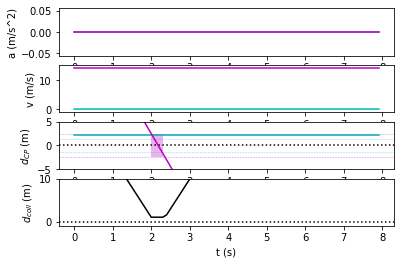

VehShortStop


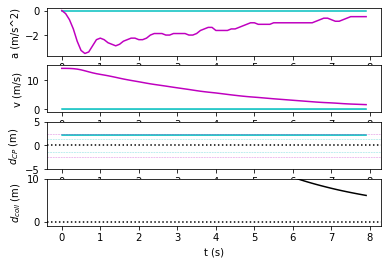

PedHesitateVehConst


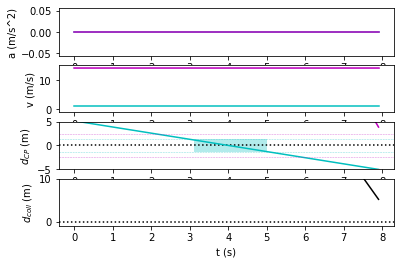

PedHesitateVehYield


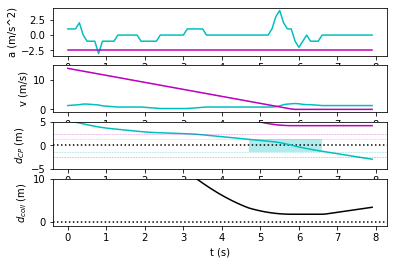

PedCrossVehYield


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


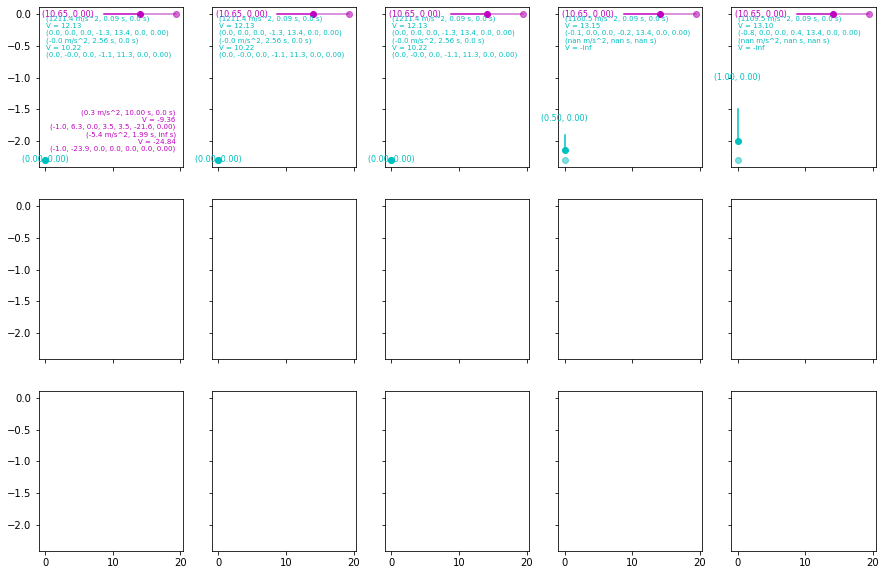

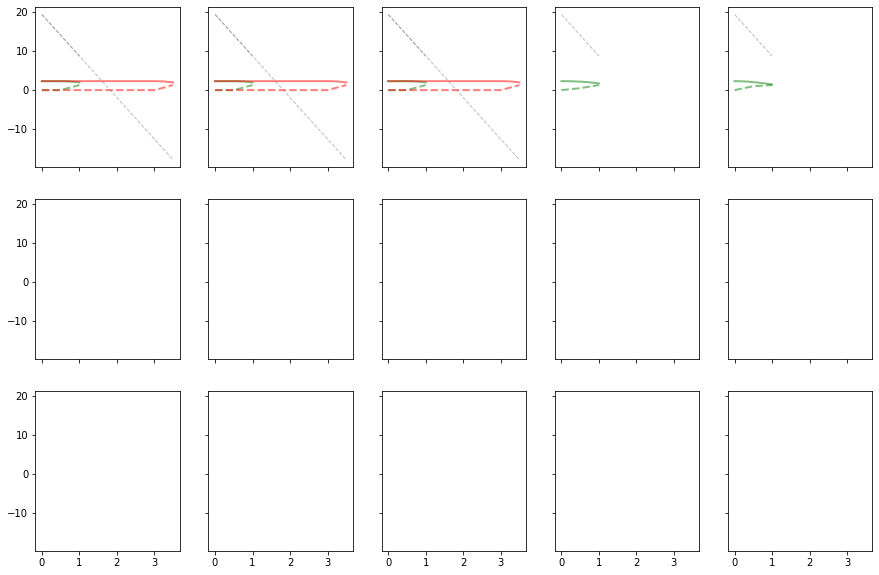

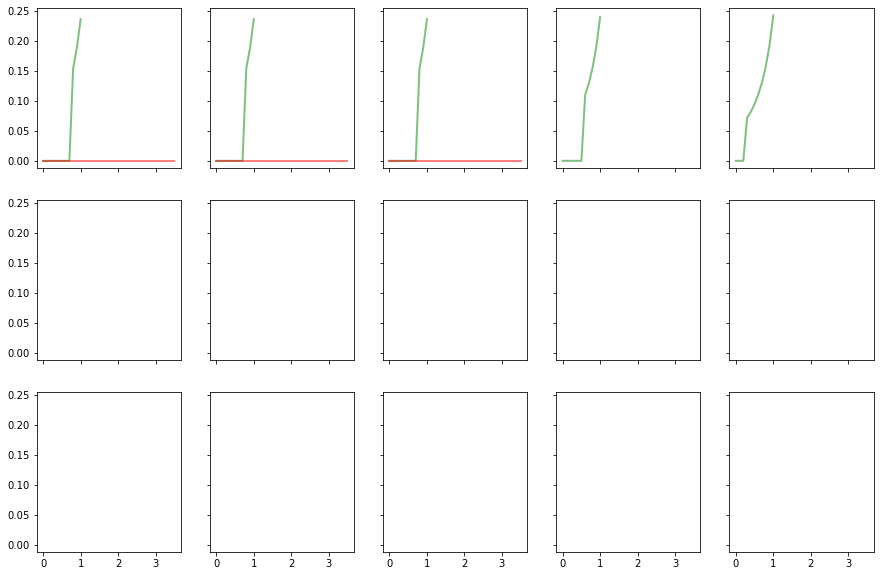

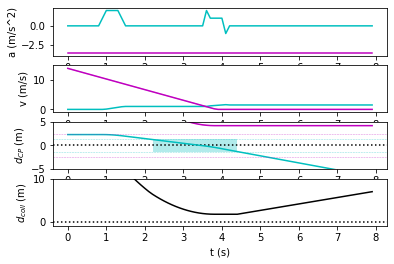

In [2]:
det_fit = det_fits['oVA']
print(det_fit.example)
det_fit.set_params(det_fit.example.params_dict)
for scenario in det_fit.scenarios.values():
    print(scenario.name)
    if scenario.name == 'PedCrossVehYield':
        snapshots = ((0.9), None)
    else:
        snapshots = (None, None)
    sim = det_fit.simulate_scenario(scenario, snapshots=snapshots)
    sim.do_plots(kinem_states=True)

## `oVAaoVAl[oBEo]BEv` does not achieve pedestrian hesitation with the yielding vehicle

I would have guessed that with `oVAl` present, there would be a parameterisation where this model hesitated for the yielding vehicle, but as we can see below the more looming-averse parameterisations instead prefer passing first by running. This may in part be due to what can be seen in the snapshot below, where neither outcome is deemed possible for the pedestrian if the vehicle is attempting to pass first. This happens because the predicted position of the vehicle under this behaviour just short of getting past the safety margin distance (collision distance + $T_s$ past the collision point; in theory with `oVAa` it should be exactly at this safety margin distance, but due to numerical limitations in this case it is just short, anyway that's not the main point here), which means that `sc_scenario.get_access_order_implications()` tries to calculate an acceleration for the pedestrian to smoothly pass behind the vehicle, but that calculation makes use of the vehicle's exit time from the conflict space, which is -Inf because the vehicle has already exited the conflict space. So should the entry/exit time really take safety margins into account to be logically sound? I think this logical flaw in the implementation has become more obvious now since I have increased the safety margins. 

ExampleParameterisation(i_parameterisation=15, params_array=array([10.  ,  0.04,  1.  ]), params_dict={'T_delta': 10.0, 'thetaDot_1': 0.04, 'beta_V': 1.0}, main_crit_dict={'veh_prio_assert': False, 'veh_short_stop': False, 'ped_hesitate_veh_yield': False, 'ped_cross_veh_yield': True}, sec_crit_dict={'ped_hesitate_veh_const': False})
thetaDot_1 = 0.04


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


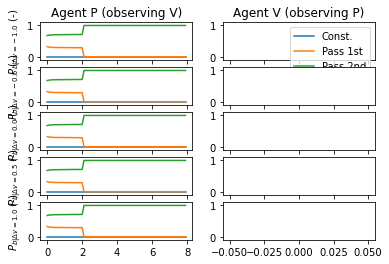

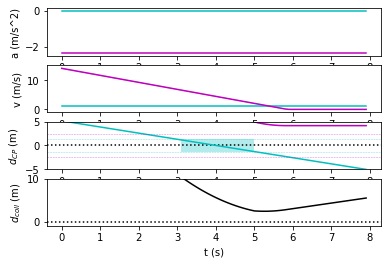

thetaDot_1 = 0.005


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


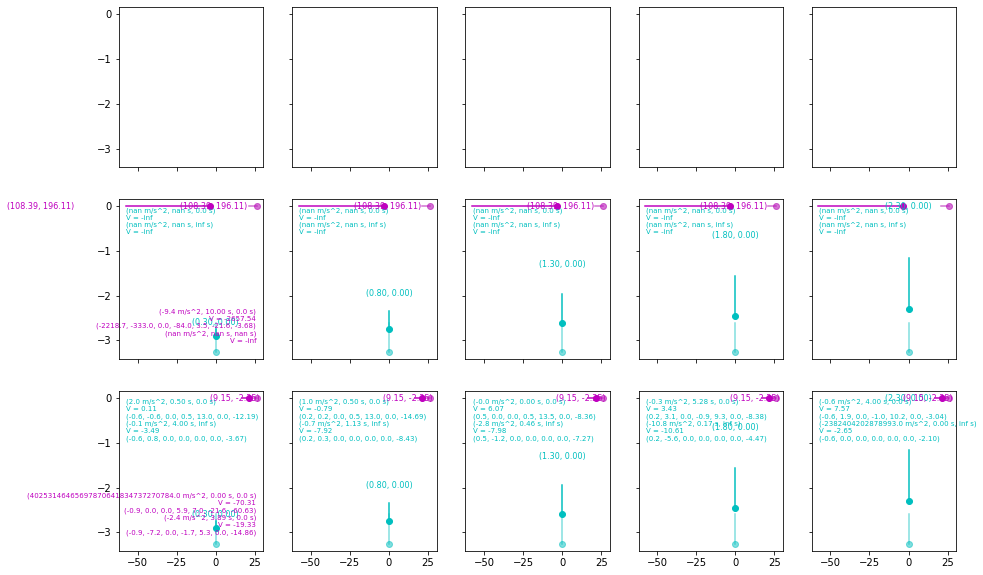

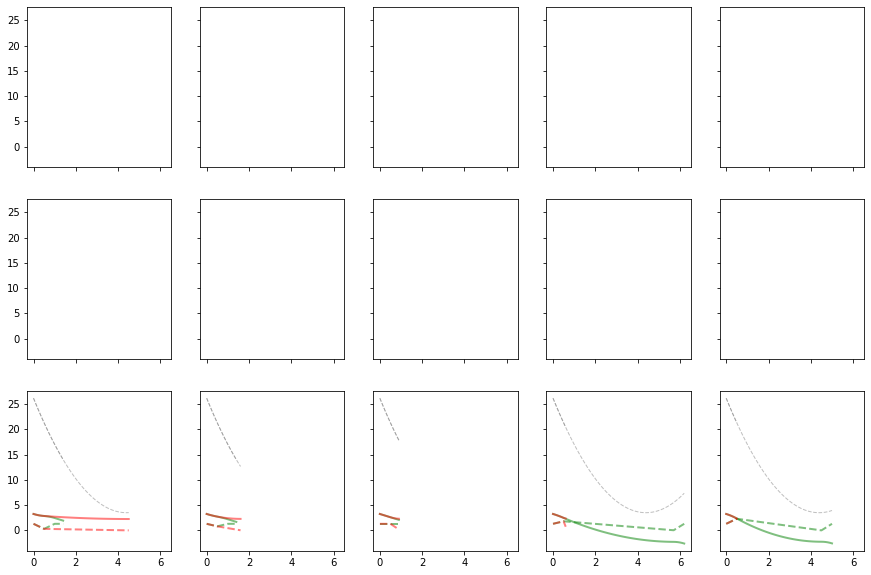

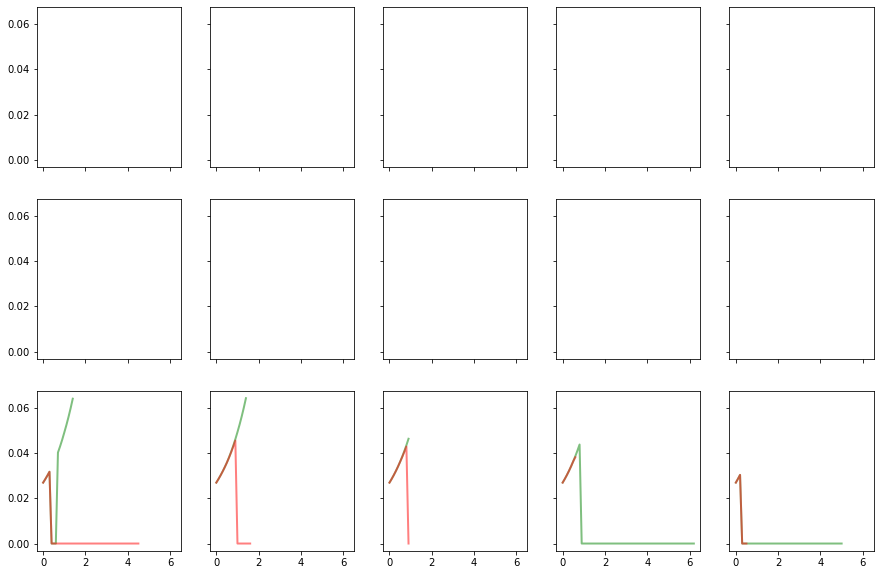

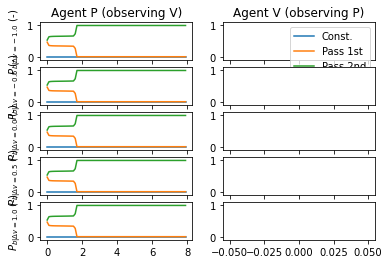

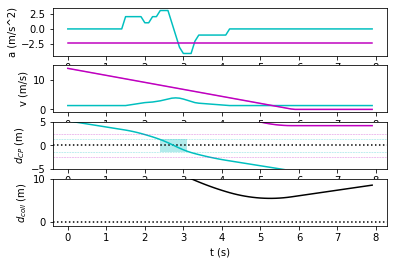

In [14]:
det_fit = det_fits['oVAaoVAloBEv']
print(det_fit.example)
params_dict = copy.copy(det_fit.example.params_dict)
for thetaDot_1 in (0.04, 0.005):
    print(f'thetaDot_1 = {thetaDot_1}')
    params_dict['thetaDot_1'] = thetaDot_1
    if thetaDot_1 == 0.005:
        snapshots = ((1.5,), None)
    else:
        snapshots = (None, None)
    det_fit.set_params(params_dict)
    sim = det_fit.simulate_scenario(sc_fitting.ONE_AG_SCENARIOS['PedHesitateVehYield'], snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)

## `oVAaoVAl[oBEo]oBEvoAI` does not achieve priority assertion or short-stopping

Below we can see that the model actually does show modest signs of priority assertion.

And in the behaviour probabilities for `VehShortStop` below one can see signs of different probabilities given different own actions, and the values at 2 s shows clearly that it would be preferable for the car if the pedestrian started walking (best value around 12, for passing in second) rather than stayed put (best value around -5, for passing in second). In other words, in theory it could be doing short-stopping. However, a closer look at the behaviour probabilities at 2 s shows that they are very near equal between non-action and the decelerating actions. Increasing $\beta_V$ increases the difference, but at $\beta_V = 10$ $P(\mbox{B passses first}|\mbox{non-action}) = 0.8933$ and $P(\mbox{B passses first}|\mbox{deceleration by 1 m/s}^2) = 0.8935$. Increasing $\beta_V$ and/or decreasing $\dot{\theta}_1$ has only a modest effect on this.

Looking closer at the snapshot, it is clear that to the vehicle, it looks like the pedestrian should just be able to go ahead and cross in front of the vehicle without worry. I think this is because the vehicle here assumes that the pedestrian sees the vehicle's acceleration, and factors it into its decision. On closer thought, it is a bit contradictory that I assume that A doesn't think B sees A's accelerations when it comes to defining B's behaviour accelerations, but I assume that A thinks B sees A's accelerations when it comes to judging the value of those behaviours...

ExampleParameterisation(i_parameterisation=15, params_array=array([10.  ,  0.04,  1.  ]), params_dict={'T_delta': 10.0, 'thetaDot_1': 0.04, 'beta_V': 1.0}, main_crit_dict={'veh_prio_assert': False, 'veh_short_stop': False, 'ped_hesitate_veh_yield': False, 'ped_cross_veh_yield': True}, sec_crit_dict={'ped_hesitate_veh_const': False})
VehPrioAssert


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


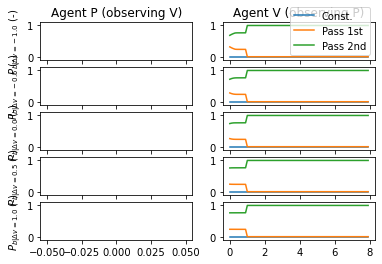

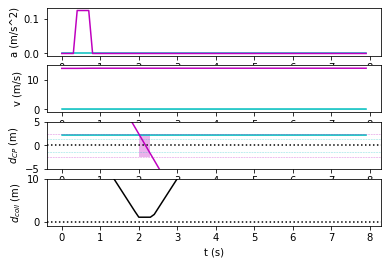

VehShortStop


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:

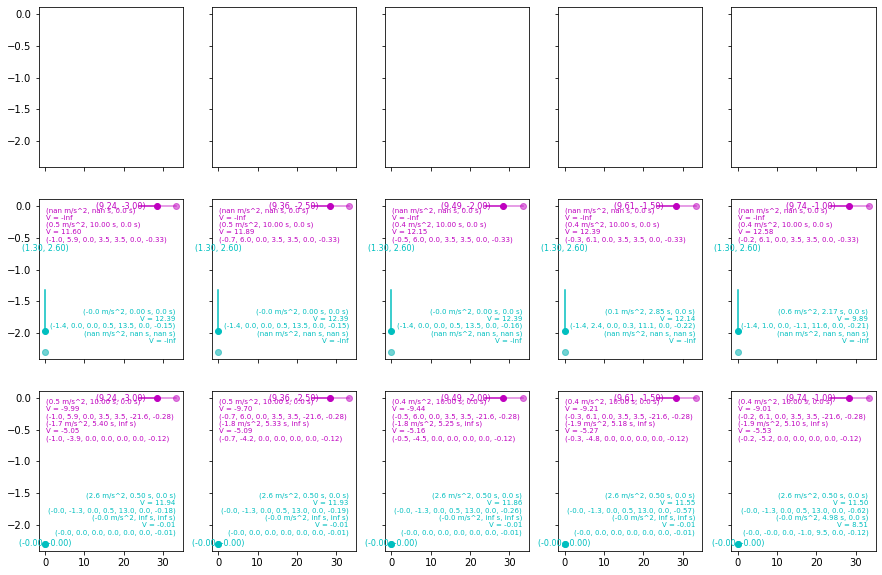

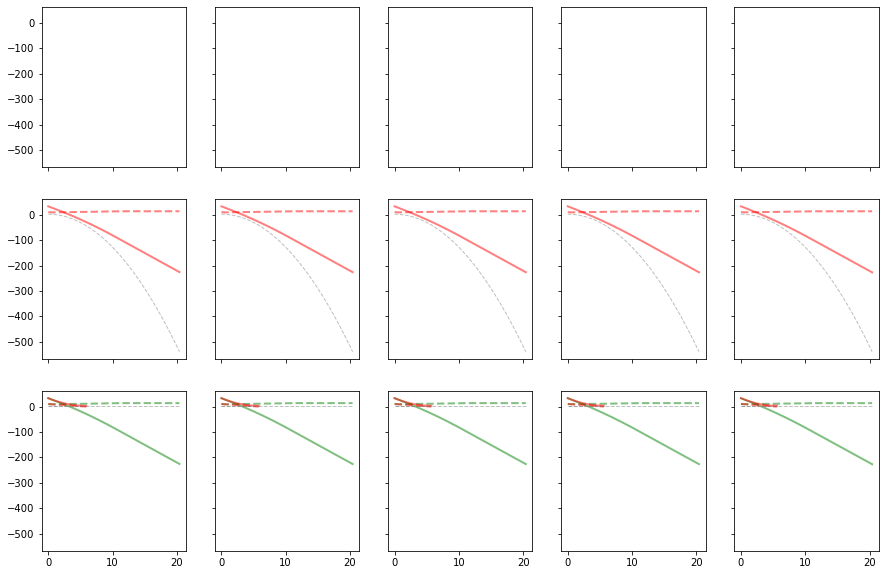

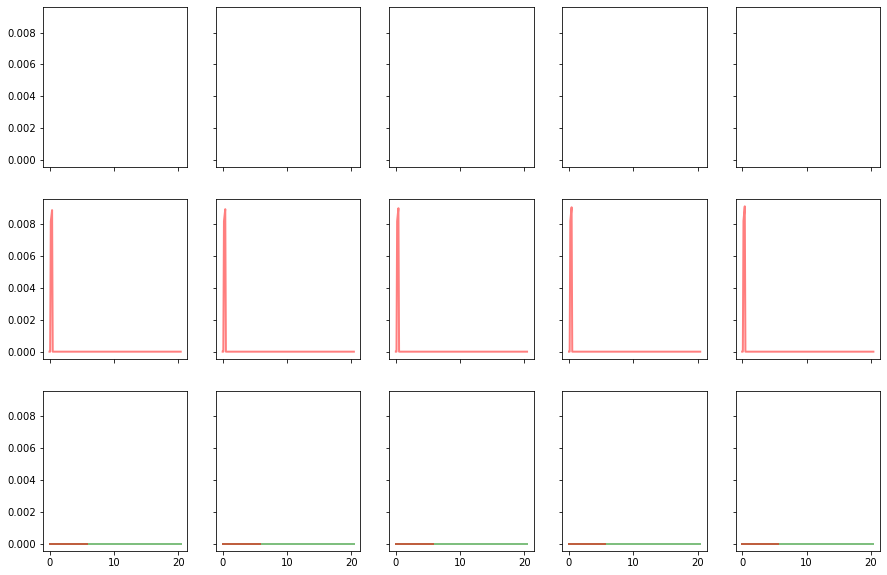

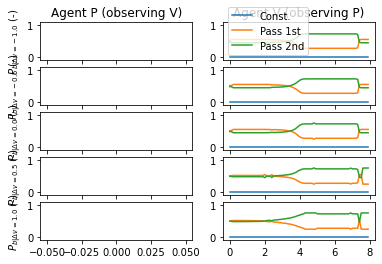

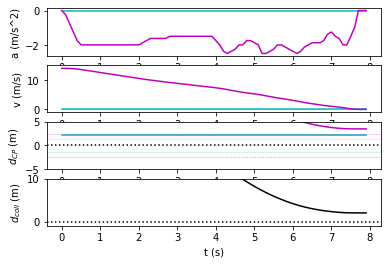

PedHesitateVehConst


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


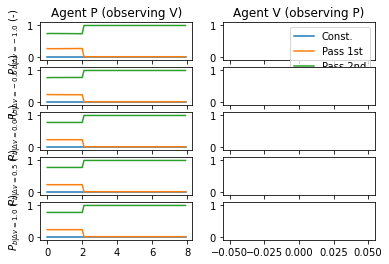

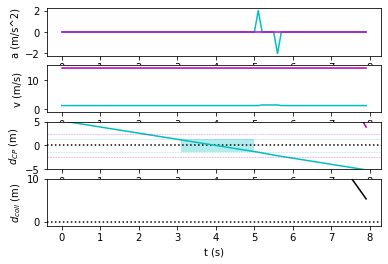

PedHesitateVehYield


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


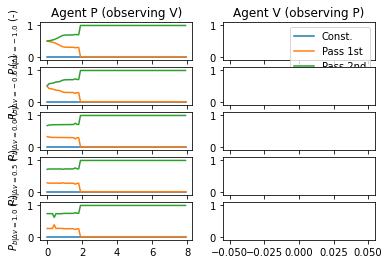

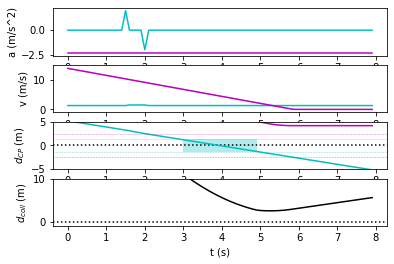

PedCrossVehYield


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


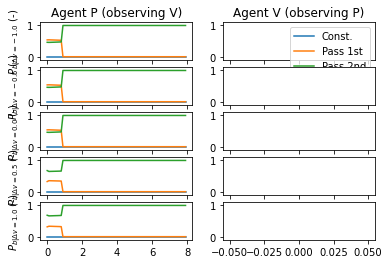

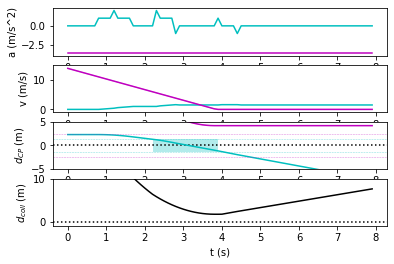

In [4]:
det_fit = det_fits['oVAaoVAloBEvoAI']
print(det_fit.example)
params_dict = copy.copy(det_fit.example.params_dict)
det_fit.set_params(params_dict)
for scenario in det_fit.scenarios.values():
    print(scenario.name)
    if scenario.name == 'VehShortStop':
        snapshots = (None, (2,))
    else:
        snapshots = (None, None)
    sim = det_fit.simulate_scenario(scenario, snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)

## `oVAoBEvoAI` does not achieve priority assertion

First of all, we can see that the behaviour probabilities are all near 1 already from the start. Zooming in, there is a small predicted effect of own acceleration on the other's behaviour, but it's like 0.996 passing second if accelerating compared to 0.995 if doing nothing.

In the snapshot we can see though that the key problem here seems to be that the values for both outcomes are -Inf for all vehicle actions if the pedestrian's behaviour is passing second. Digging into the code I am realising that this is because `SCAgent.get_predicted_other_state()` was changed a while back (commit 2021-11-06) during the integration of the new perception module, to calculate predicted other state itself rather than let the other agent do that (since with noisy perception the prediction will typically not be from the other agent's true current state). In this modification I didn't protect against reversing. In the new scenario definition here, where the pedestrian starts exactly at its safety margin distance, the estimated acceleration needed to pass in second is a very small but non-zero negative acceleration, which in turn in `sc_scenario.get_entry_exit_times()` results in a negative entry time being estimated, which later on results in `sc_scenario.get_acc_to_be_at_dist_at_time()` being given a negative `target_time`, which it rightly considers impossible to achieve; the problem is with both of those other functions - if either of them had worked more appropriately this bug would have been avoided.

ExampleParameterisation(i_parameterisation=10, params_array=array([10.,  5.]), params_dict={'T_delta': 10.0, 'beta_V': 5.0}, main_crit_dict={'veh_prio_assert': False, 'veh_short_stop': True, 'ped_hesitate_veh_yield': True, 'ped_cross_veh_yield': True}, sec_crit_dict={'ped_hesitate_veh_const': False})
VehPrioAssert


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


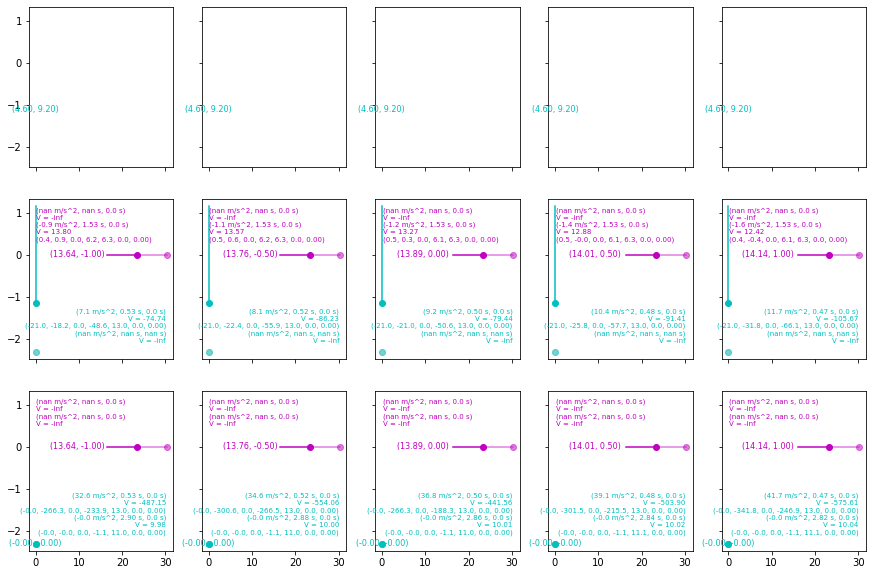

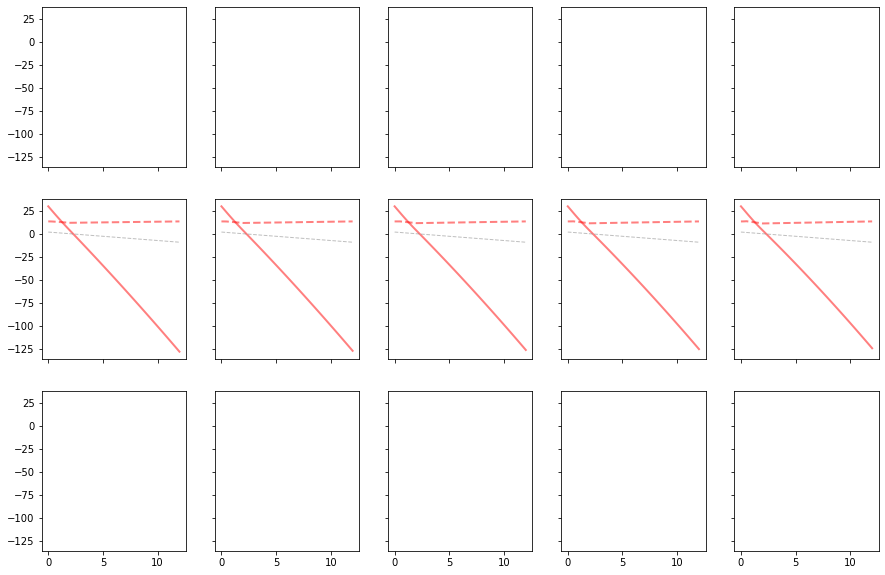

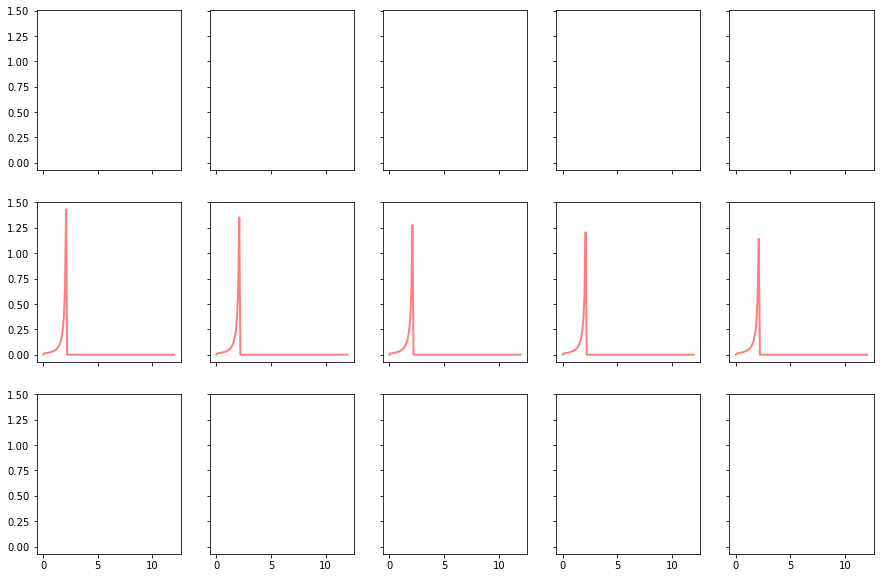

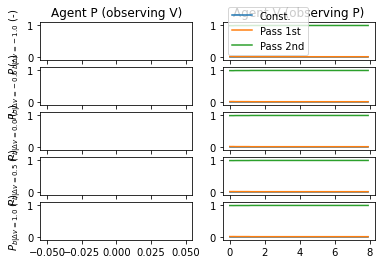

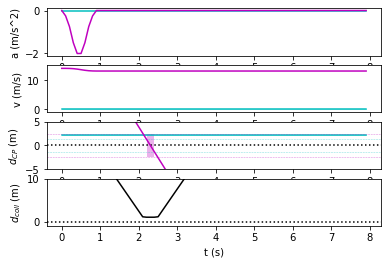

VehShortStop


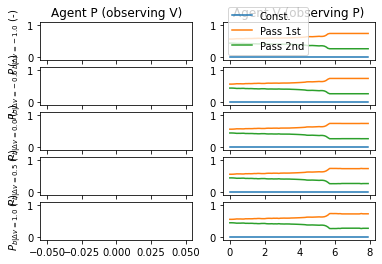

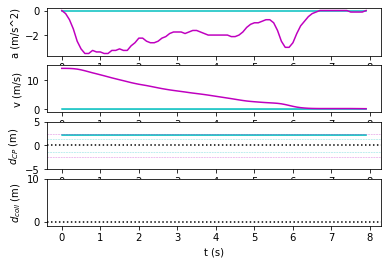

PedHesitateVehConst


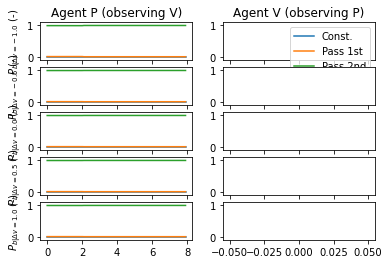

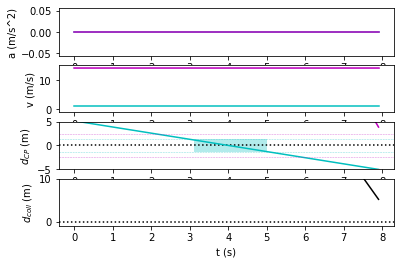

PedHesitateVehYield


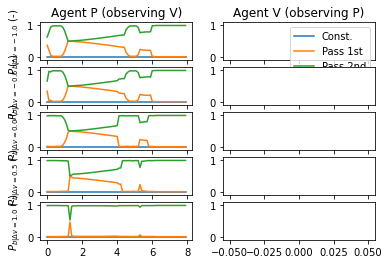

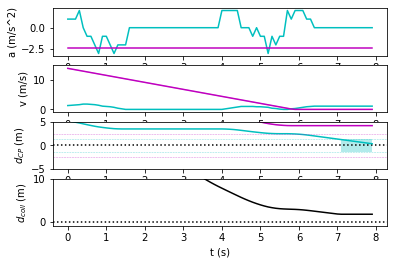

PedCrossVehYield


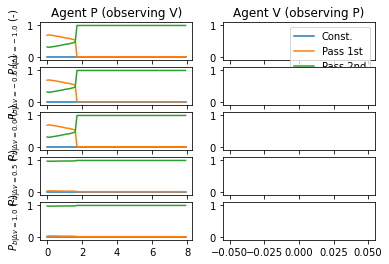

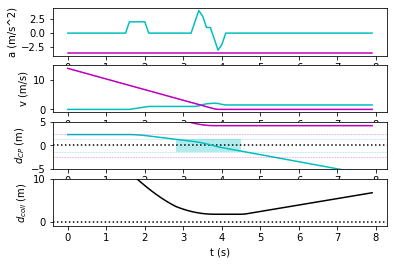

In [6]:
import copy
det_fit = det_fits['oVAoBEvoAI']
print(det_fit.example)
params_dict = copy.copy(det_fit.example.params_dict)
#params_dict['beta_V'] = 3
det_fit.set_params(params_dict)
for scenario in det_fit.scenarios.values():
    print(scenario.name)
    if scenario.name == 'VehPrioAssert':
        snapshots = (None, (0,))
    else:
        snapshots = (None, None)
    sim = det_fit.simulate_scenario(scenario, snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)

## `oVAoVAloBEo/oBEv` achieves priority assertion 

We can see below that the reason this model speeds up here is actually the same bug as mentioned just above, making it look like to the model like the only non-disastrous (value > -Inf) outcome is to pass behind a pedestrian that is adopting a pass-first behaviour. This is still a pretty bad outcome for the vehicle (value around -60), but the model apparently finds that a slightly less bad solution from the perspective of anticipated looming is to speed up a little first and then decelerate more - this causes the anticipated looming peak to be slightly lower (again see the snapshot below), apparently because the anticipated speed at the end of that larger deceleration is lower. This looming effect is a slightly awkward implication of the way the model is set up, and something to keep an eye on (added note in SCPaper README), but since I have now so far only see it happen for this special/buggy situation, and with a very low $\dot{\theta}_1$ value also (encouraging the model to really prioritise its looming aversion over for example acceleration discomfort), I will leave it as it is for the time being.

ExampleParameterisation(i_parameterisation=0, params_array=array([1.e+01, 5.e-03, 1.e+00]), params_dict={'T_delta': 10.0, 'thetaDot_1': 0.005, 'beta_V': 1.0}, main_crit_dict={'veh_prio_assert': True, 'veh_short_stop': False, 'ped_hesitate_veh_yield': True, 'ped_cross_veh_yield': False}, sec_crit_dict={'ped_hesitate_veh_const': True})
VehPrioAssert


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


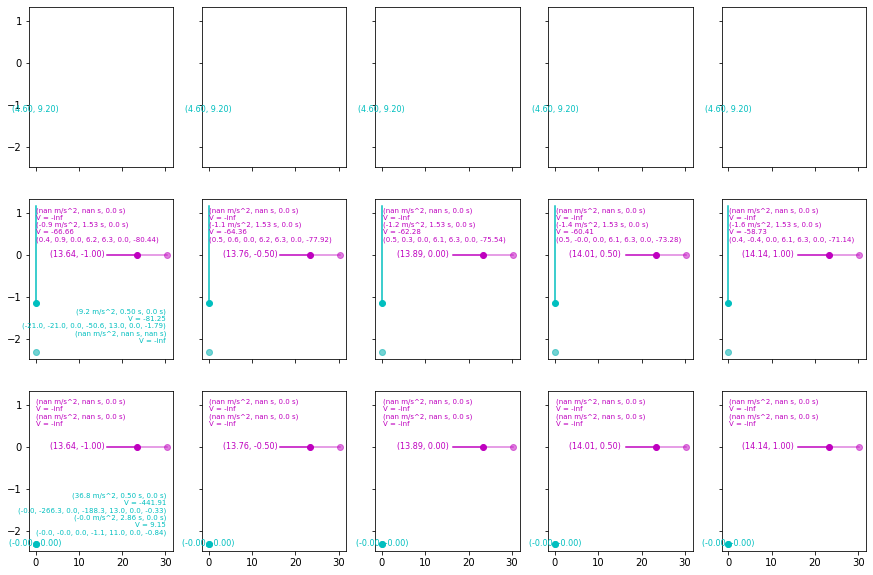

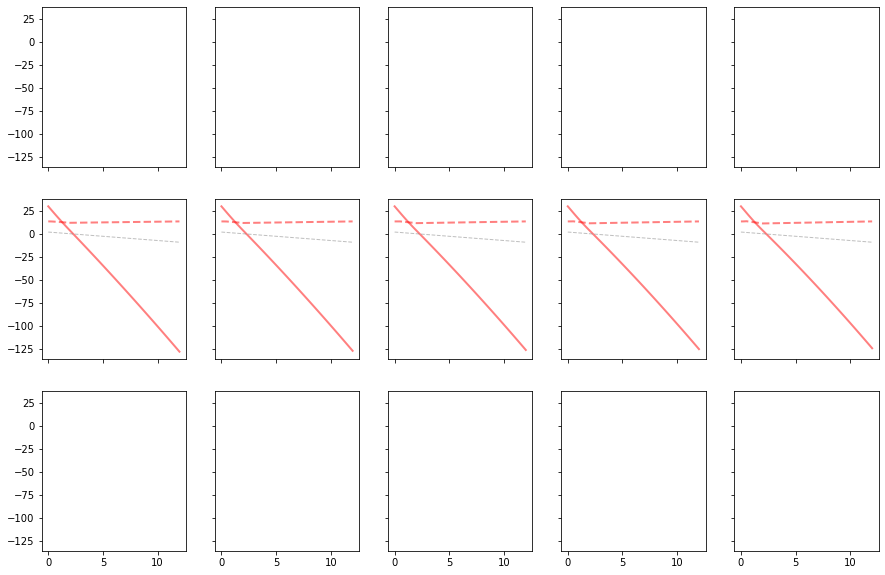

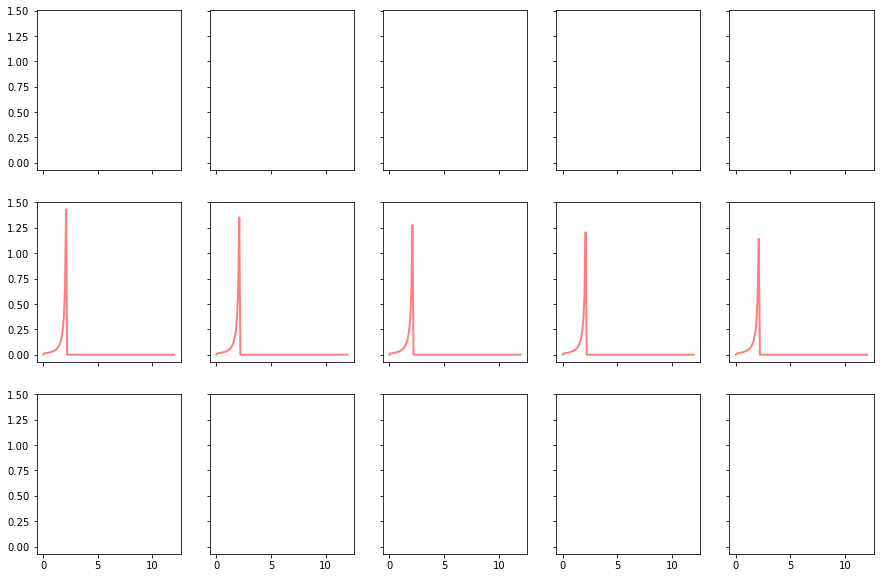

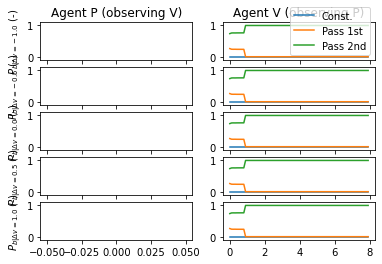

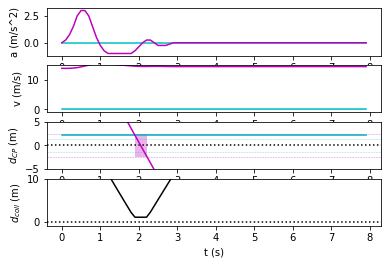

VehShortStop


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


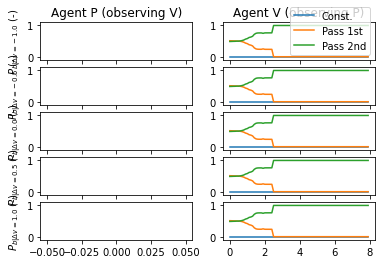

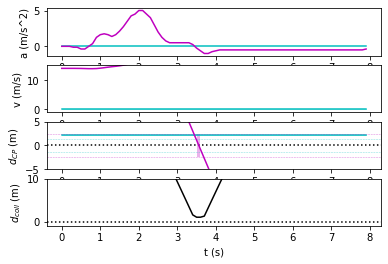

PedHesitateVehConst


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


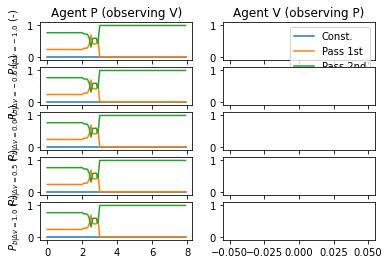

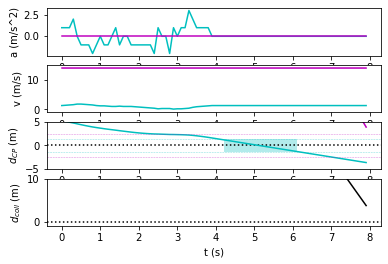

PedHesitateVehYield


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


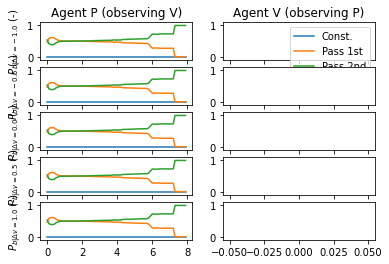

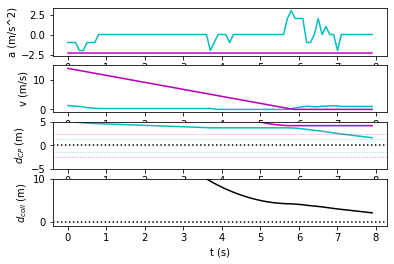

PedCrossVehYield


C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


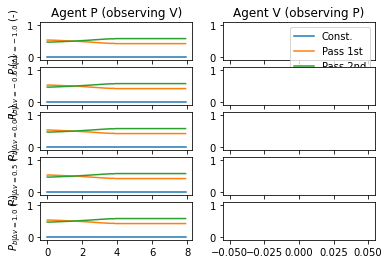

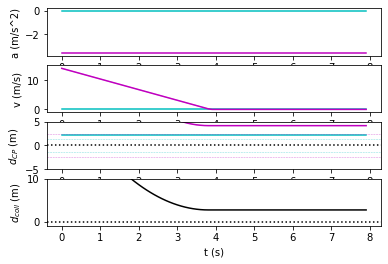

In [10]:
det_fit = det_fits['oVAoVAloBEv']
print(det_fit.example)
params_dict = copy.copy(det_fit.example.params_dict)
#params_dict['beta_V'] = 3
det_fit.set_params(params_dict)
for scenario in det_fit.scenarios.values():
    print(scenario.name)
    if scenario.name == 'VehPrioAssert':
        snapshots = (None, (0,))
    else:
        snapshots = (None, None)
    sim = det_fit.simulate_scenario(scenario, snapshots=snapshots)
    sim.do_plots(kinem_states=True, beh_probs=True)